In [1]:
from glob import glob
import torch
import torch_optimizer
from torch_snippets import *
from torchvision import transforms, datasets, models, utils
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision.ops import nms, RoIPool
from torchsummary import summary
from selectivesearch import selective_search
from PIL import ImageTk, Image

import numpy as np
import pandas as pd
import selectivesearch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tkinter
import tkinter.ttk
import tkinter.font as tkFont
plt.rc('font', family='NanumGothic')

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**데이터 불러오기 및 확인**

train: 2520개, valid 데이터 개수: 720개, test 데이터 개수 : 360개

In [3]:
train_path = './data/img_dataset/train/image'
valid_path = './data/img_dataset/valid/image'
test_path = './data/img_dataset/test/image'

In [4]:
train_df = pd.read_csv('./data/train_df.csv')
valid_df = pd.read_csv('./data/valid_df.csv')
test_df = pd.read_csv('./data/test_df.csv')

In [5]:
class OpenImages(Dataset):
    def __init__(self, df, image_dir):
        self.image_dir = image_dir
        self.files = glob(self.image_dir+'/*/*')
        self.df = df
        self.unique_images = df['image_id'].unique()
        self.width = df['width']
        self.height = df['height']  
    def __len__(self): 
        return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        width = self.width[ix]
        height = self.height[ix]
        image_path = find(image_id, self.files)
        image = cv2.imread(image_path, 1)[...,::-1]
        # 해당 데이터의 경우, 고화질 이미지로 selective search에 너무 많은 시간이 걸려 사이즈 조정
        image = cv2.resize(image, 
                           dsize=(int(width / 8), int(height / 8)),
                           interpolation=cv2.INTER_AREA)
        df = self.df.copy()
        df = df[df['image_id'] == image_id]
        boxes = df[['xmin', 'ymin', 'xmax', 'ymax']].values
        boxes = (boxes / 8).astype(np.uint16).tolist()
        classes = df['label'].values.tolist()
        return image, boxes, classes, image_path

In [6]:
train_ds = OpenImages(train_df, train_path)
valid_ds = OpenImages(valid_df, valid_path)
test_ds = OpenImages(test_df, test_path)

In [7]:
ds = ConcatDataset([train_ds, valid_ds, test_ds])

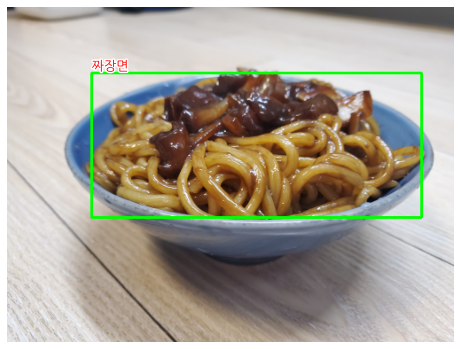

In [8]:
im, bbs, clss, _ = ds[12]
show(im, bbs=bbs, texts=clss, sz=8, text_sz=13);

**Selective search**

In [9]:
def extract_candidates(img):
    img_lbl, regions = selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05 * img_area): continue
        if r['size'] > (1 * img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

In [10]:
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width < 0) or (height < 0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined + epsilon)
    return iou

In [11]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx, cy, cX, cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x, _y, _X, _Y = bbs[best_iou_at]
        
        if best_iou > 0.3:
            clss.append(labels[best_iou_at])
        else :
            clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W, H, W, H])
        deltas.append(delta)
        rois.append(candidate / np.array([W, H, W, H]))
        
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [12]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
targets = targets.sort_values('label')
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

**DataLoader 생성**

In [13]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    img = normalize(img)
    return img.to(device).float()

def decode(_y):
    _, preds = _y.max(-1)
    return preds

In [14]:
class ImageDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self):
        return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas)
        return image, rois, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        inputs, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (512, 512))
            inputs.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix] * len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        inputs = torch.cat(inputs).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return inputs, rois, rixs, labels, deltas

In [15]:
n = len(train_df)
m = len(train_df) + len(valid_df)


train_dataset = ImageDataset(FPATHS[:n], ROIS[:n], CLSS[:n], 
                             DELTAS[:n], GTBBS[:n])
valid_dataset = ImageDataset(FPATHS[n:m], ROIS[n:m], CLSS[n:m], 
                            DELTAS[n:m], GTBBS[n:m])
test_dataset = ImageDataset(FPATHS[m:], ROIS[m:], CLSS[m:], 
                            DELTAS[m:], GTBBS[m:])

In [16]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          collate_fn=train_dataset.collate_fn, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False,
                         collate_fn=valid_dataset.collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,
                         collate_fn=test_dataset.collate_fn, drop_last=True)

**Fastrcnn 모델 정의**

In [17]:
def get_model(alpha=30):
    model = models.inception_v3(pretrained=True, aux_logits=False)    
    # Layer Freeze 설정
    n = len(list(model.parameters()))
    for i, param in enumerate(model.parameters()):        
        if i < n - alpha:
            param.requires_grad = False    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 12)
    return model.to(device)

In [42]:
class UFC(nn.Module):
    def __init__(self):
        super().__init__()
        # 분류기에서 음식 이미지 데이터셋으로 학습하여 Fine Tuning한 모델을 backbone으로 사용
        backbone = get_model(alpha=15)
        load_path = './model/classifier.pt'
        backbone.load_state_dict(torch.load(load_path))
        self.seq = nn.Sequential(*list(backbone.children())[:-3])
        # Feature map의 크기가 5X5, 이미지 크기 512X512
        self.roipool = RoIPool(3, spatial_scale=5/512)
        # Inception Module C의 경우, 서로 다른 4개의 conv블록을 concat하기 때문에 뒤에 4를 곱해줌
        feature_dim = 512*3*3*4
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, inputs, rois, ridx):
        res = inputs
        res = self.seq(res) 
        rois = torch.cat([ridx.unsqueeze(-1), rois*512], dim=-1)
        res = self.roipool(res, rois)
        feat = res.view(len(res), -1)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0        
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

**모델 학습**

In [43]:
def train_batch(inputs, model, optimizer, criterion):
    inputs, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(inputs, rois, rixs)
    loss, cls_loss, loc_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), cls_loss, loc_loss, accs.cpu().numpy()

In [44]:
@torch.no_grad()
def valid_batch(inputs, model, criterion):
    inputs, rois, rixs, clss, deltas = inputs
    model.eval()
    _clss,_deltas = model(inputs, rois, rixs)
    loss, cls_loss, loc_loss = criterion(_clss, _deltas, clss, deltas)
    _clss = decode(_clss)
    accs = clss == _clss
    return loss.detach(), cls_loss, loc_loss, accs.cpu().numpy()

In [45]:
model = UFC().to(device)
criterion = model.calc_loss
optimizer = torch_optimizer.AdaBound(model.parameters(), lr=5e-4)

EPOCHS = 10
log = Report(EPOCHS)
for EPOCH in range(EPOCHS):
    # Train
    _n = len(train_loader)
    for ix, batch in enumerate(train_loader):
        loss, cls_loss, loc_loss, accs = train_batch(batch, model, optimizer, criterion)
        pos = (EPOCH + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_cls_loss=cls_loss, 
                       trn_loc_loss=loc_loss, trn_acc=accs.mean(), end='\r')    
    # Validation
    _n = len(valid_loader)
    for ix, batch in enumerate(valid_loader):
        loss, cls_loss, loc_loss, accs = valid_batch(batch, model, criterion)
        pos = (EPOCH + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_cls_loss=cls_loss, 
                val_loc_loss=loc_loss, val_acc=accs.mean(), end='\r')
        
    log.report_avgs(EPOCH + 1)

EPOCH: 1.000	trn_loss: 3.745	trn_cls_loss: 2.166	trn_loc_loss: 0.158	trn_acc: 0.396	val_loss: 2.436	val_cls_loss: 1.777	val_loc_loss: 0.066	val_acc: 0.471	(549.12s - 4942.07s remaining)
EPOCH: 2.000	trn_loss: 1.969	trn_cls_loss: 1.355	trn_loc_loss: 0.061	trn_acc: 0.549	val_loss: 1.731	val_cls_loss: 1.127	val_loc_loss: 0.060	val_acc: 0.608	(1099.60s - 4398.39s remaining)
EPOCH: 3.000	trn_loss: 1.445	trn_cls_loss: 0.871	trn_loc_loss: 0.057	trn_acc: 0.705	val_loss: 1.396	val_cls_loss: 0.781	val_loc_loss: 0.062	val_acc: 0.724	(1649.53s - 3848.91s remaining)
EPOCH: 4.000	trn_loss: 1.081	trn_cls_loss: 0.548	trn_loc_loss: 0.053	trn_acc: 0.815	val_loss: 1.366	val_cls_loss: 0.734	val_loc_loss: 0.063	val_acc: 0.750	(2201.48s - 3302.22s remaining)
EPOCH: 5.000	trn_loss: 0.977	trn_cls_loss: 0.438	trn_loc_loss: 0.054	trn_acc: 0.848	val_loss: 1.272	val_cls_loss: 0.710	val_loc_loss: 0.056	val_acc: 0.757	(2754.37s - 2754.37s remaining)
EPOCH: 6.000	trn_loss: 0.784	trn_cls_loss: 0.288	trn_loc_loss: 0.0

**모델 평가**

100%|███████████████████████████████████████| 111/111 [00:00<00:00, 3206.72it/s]


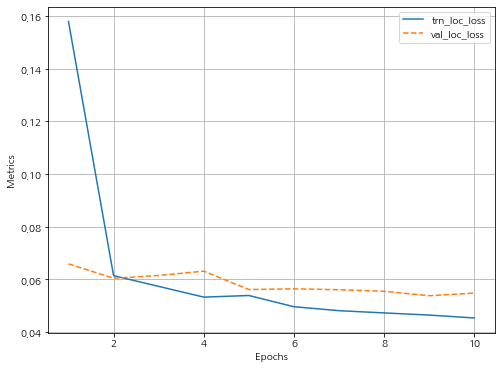

In [46]:
log.plot_epochs(['trn_loc_loss', 'val_loc_loss']);

100%|███████████████████████████████████████| 111/111 [00:00<00:00, 2775.68it/s]


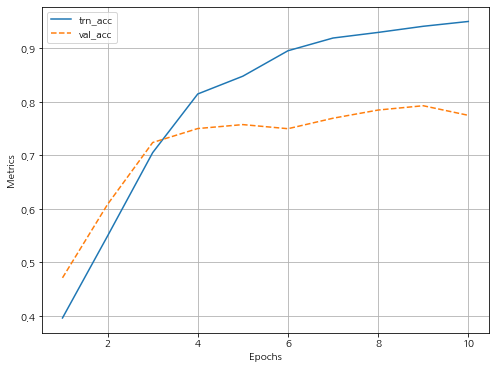

In [47]:
# Plotting training and validation metrics
log.plot_epochs(['trn_acc', 'val_acc']);

**예측한 바운딩 박스 출력**

In [112]:
@torch.no_grad()
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (512, 512))
    candidates = extract_candidates(img)
    candidates = [(x, y, x+w, y+h) for x, y, w, h in candidates]
    inputs = preprocess_image(img/255.)[None]
    rois = [[x/512, y/512, X/512, Y/512] for x, y, X, Y in candidates]
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    model.eval()
    probs, deltas = model(inputs, rois, rixs)
    confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]    
    bbs = bbs.astype(np.uint16)
    
    return img, bbs.tolist(), clss.tolist()

In [121]:
def image_show(img, bbs, clss, file_path):    
    if len(confs) == 0:
        plt.imshow(img)
        plt.title('No objects');
    else:
        show(img, bbs=bbs, texts=[target2label[c] for c in clss], 
             text_sz=12, save_path=file_path);

**Tkinter를 활용한 GUI 코딩**

In [122]:
def nutrient(label, filepath):

    food = db.query("클래스 == @label").values.squeeze()
    
    # GUI창을 생성하고 라벨을 설정한다.
    root=tkinter.Tk()
    root.title("식품 영양성분DB")
    root.geometry("950x950")
    root.resizable(False, False)

    #이미지 로드
    img_path = ImageTk.PhotoImage(Image.open(filepath), master=root)
    lbl1 = tkinter.Label(root, image=img_path)
    lbl1.image = img_path
    lbl1.grid(row=1, column=0)
    
    # 표 생성하기. colums는 컬럼 이름, displaycolums는 실행될 때 보여지는 순서다.
    treeview=tkinter.ttk.Treeview(root, columns=["one", "two","three"], displaycolumns=["one","two","three"])
    treeview.grid(row=2, column=0)

    # 각 컬럼 설정. 컬럼 이름, 컬럼 넓이, 정렬 등
    treeview.column("#0", width=234, anchor="center")
    treeview.heading("#0", text="index", anchor="center")
    
    treeview.column("#1", width=234, anchor="center")
    treeview.heading("one", text="영양성분", anchor="center")

    treeview.column("#2", width=234, anchor="center")
    treeview.heading("two", text="mg/g", anchor="center")

    treeview.column("#3", width=234, anchor="center")
    treeview.heading("three", text="%(kcal)", anchor="center")

    # 표에 삽입될 데이터
    treelist=[("나트륨", str(food[3])+"mg", "0%"), ("탄수화물", str(food[4])+"g", str(round(food[4]*400/food[2], 2))+"%"), 
              ("당류", str(food[5])+"g", "0%"), ("지방", str(food[6])+"g", str(round(food[6]*900/food[2], 2))+"%"), 
              ("트랜스지방", str(food[7])+"g", "0%"), ("포화지방", str(food[8])+"g", "0%"), 
              ("콜레스테롤", str(food[9])+"mg", "0%"), ("단백질", str(food[10])+"g", str(round(food[10]*400/food[2], 2))+"%")]

    fontStyle2 = tkFont.Font(family="Lucida Grande", size=12)
    lbl2 = tkinter.Label(root, text="[ "+str(food[1])+": "+str(food[2])+"kcal"+" ]", font=fontStyle2, pady=10)
    lbl2.grid(row=3, column=0)
    
    # 표에 데이터 삽입
    for i in range(len(treelist)):
        treeview.insert('', 'end', text=i, values=treelist[i], iid=str(i)+"번")

    # GUI 실행
    return root.mainloop()

**식품영양성분DB 불러오기**

In [135]:
db = pd.read_csv('./data/식품영양성분DB_12.csv')

In [145]:
db.head()

,식품코드,식품명,에너지(㎉),나트륨(㎎),탄수화물(g),총당류(g),지방(g),트랜스 지방산(g),총 포화 지방산(g),콜레스테롤(㎎),단백질(g)
0,9011002,갈치조림,100.000,567.550,6.200,6.30,2.800,0.000,0.600,50.490,12.700
1,1014001,김치볶음밥,550.000,1549.800,51.900,45.90,30.300,0.100,4.700,232.340,17.600
2,10012003,돈까스,623.828,574.078,38.489,3.66,37.545,0.263,9.115,98.162,32.992
3,6012004,떡갈비,403.000,807.590,4.900,0.80,23.600,0.800,8.600,136.070,42.800
4,8014001,떡볶이,260.000,703.120,46.700,7.90,5.300,0.000,0.500,4.210,6.300


In [143]:
clss_dic = {name: label for label, name in target2label.items()}

In [147]:
db['클래스'] = db['식품명'].map(clss_dic)

**single 레이블 데이터(Test dataset 일부)**

In [162]:
img, bbs, clss = test_predictions(test_dataset[1][-1])

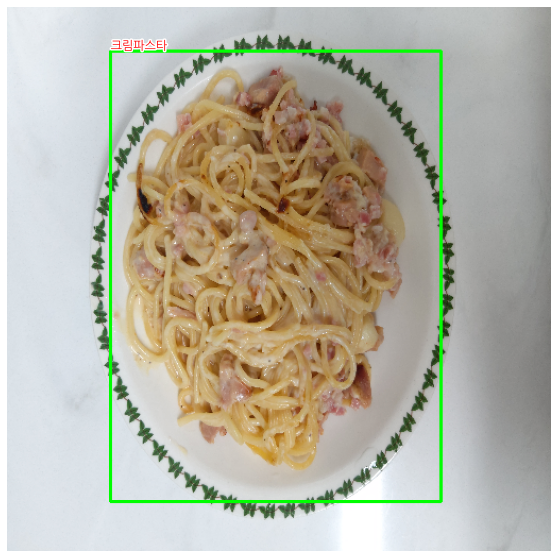

In [163]:
image_show(img, bbs, clss, './data/image1.jpg')

In [164]:
nutrient(clss[0], './data/image1.jpg')

**multi 레이블 데이터(구글 웹 이미지)**

In [165]:
img, bbs, clss = test_predictions('./data/real_world_data/test.jpg')

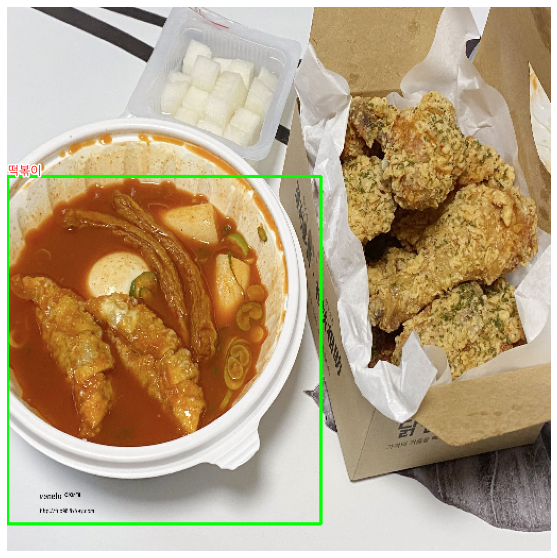

In [166]:
image_show(img, bbs, clss, './data/image2.jpg')

In [167]:
nutrient(clss[0], './data/image2.jpg')